https://neo4j.com/graphacademy/online-training/data-science/part-2/

/media/lnr-ai/applications/./neo4j-desktop-offline-1.2.7-x86_64.AppImage 

In [1]:
import pandas as pd
from py2neo import Graph
graph = Graph("bolt://localhost:7687", user='neo4j', password='newPassword')
# graph = Graph()

In [2]:
import matplotlib 
import matplotlib.pyplot as plt

### Part 1, EDA

https://colab.research.google.com/github/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/02_EDA.ipynb#scrollTo=0r69d4ek5huR

#### Is the Neo4J db up and running?

In [3]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [(_-2:Merchant {constraints: ['CONSTRAINT ON ( merchant:Merchant ) ASSERT (merchant.franchisename) IS UNIQUE'], indexes: [], name: 'Merchant'}),
   (_-1:Client {constraints: ['CONSTRAINT ON ( client:Client ) ASSERT (client.dedupestatic) IS UNIQUE'], indexes: [], name: 'Client'}),
   (_-3:Segment {constraints: ['CONSTRAINT ON ( segment:Segment ) ASSERT (segment.seg_l3_num) IS UNIQUE'], indexes: [], name: 'Segment'})],
  'relationships': [(Client)-[:TRANSACTED_AT {}]->(Merchant)]}]

#### In the browser, execute the following command:
MATCH (c:Client)-[transacted_at:TRANSACTED_AT]->(merchant:Merchant) RETURN c,transacted_at,merchant LIMIT 50

#### Let's drill down into the Nedbank Behaviour db. How many nodes do we have for each label?

In [4]:
# https://neo4j.com/graphacademy/online-training/data-science/part-2/
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Segment,35
1,Merchant,92388
0,Client,2216269


#### Visualize counts:

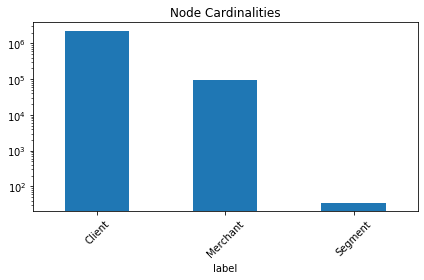

In [5]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Here are the types of relationships and their counts in the db:

In [6]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
0,TRANSACTED_AT,9914835


#### Visualize relationship cardinalities:

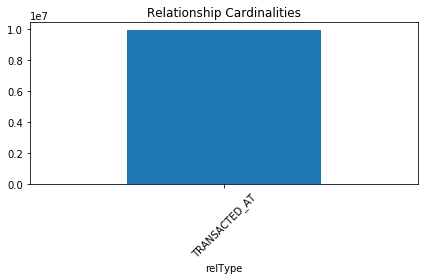

In [7]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Explore client nodes:

Lets look at the relationship COUNTS between client and Merchant:

In [8]:
exploratory_client_query = """
MATCH (client:Client)-[transacted_at:TRANSACTED_AT]->(merchant:Merchant)
WITH client.dedupestatic as client, count(transacted_at) as number_merchant_relationships
RETURN client, number_merchant_relationships
ORDER BY number_merchant_relationships
"""
df=graph.run(exploratory_client_query).to_data_frame()
df.tail()

,client,number_merchant_relationships
1908916,9.10300001710005e+19,1517
1908917,9.10500001710006e+19,1877
1908918,9.10400001710005e+19,1952
1908919,9.10400001710006e+19,2051
1908920,9.10600001710006e+19,2069


In [9]:
int(float(list(df['client'])[-1]))

91060000171000594432

Choose one client Dedupegroup = 91060000171000594432, the one with the most relationships.

In [10]:
dedupestatic=list(df['client'])[-1]
a_client_query = """
MATCH (client:Client {dedupestatic:$dedupestatic})-[:TRANSACTED_AT]->(merchant:Merchant)
WITH client.dedupestatic as client, merchant.franchisename as franchisename, merchant.companyname as companyname
RETURN client, franchisename,companyname
"""
graph.run(a_client_query, {"dedupestatic": dedupestatic}).to_data_frame()

,client,franchisename,companyname
0,9.10600001710006e+19,MEDIRITE KIMBERLEY,MEDIRITE
1,9.10600001710006e+19,CLICKS HEIDELBERG,CLICKS
2,9.10600001710006e+19,MEDIRITE - BARTLETT,MEDIRITE
3,9.10600001710006e+19,WOOLWORTHS NORWOOD,WOOLWORTHS
4,9.10600001710006e+19,PNP POLOKWANE,PNP
...,...,...,...
2064,9.10600001710006e+19,PNP UMHLANGA,PNP
2065,9.10600001710006e+19,SUPERSPAR GATEWAY HERMANU,SPAR
2066,9.10600001710006e+19,PEP VEREENIGING,PEP
2067,9.10600001710006e+19,SHOPRITE GRAAFF REINET,SHOPRITE


In [11]:
a_client_query

'\nMATCH (client:Client {dedupestatic:$dedupestatic})-[:TRANSACTED_AT]->(merchant:Merchant)\nWITH client.dedupestatic as client, merchant.franchisename as franchisename, merchant.companyname as companyname\nRETURN client, franchisename,companyname\n'

#### Now let's explore the Merchant data. 

This looks at the COMPANY level first and counts the unique relationships:

In [12]:
exploratory_company_query = """
MATCH (client:Client)-[transacted_at:TRANSACTED_AT]->(merchant:Merchant)
WHERE merchant.companyname<>'Unknown'
WITH merchant.companyname as company, count(transacted_at) as number_company_relationships
RETURN company, number_company_relationships
ORDER BY number_company_relationships DESC
"""
df=graph.run(exploratory_company_query).to_data_frame()
df.head()

,company,number_company_relationships
0,SPAR,1112968
1,PNP,1011818
2,SHOPRITE,647844
3,CHECKERS,595026
4,WOOLWORTHS,521081


This looks at the MERCHANT level and counts the unique relationships:

In [13]:
exploratory_franchise_query = """
MATCH ()-[transacted_at:TRANSACTED_AT]->(merchant:Merchant)
WHERE merchant.companyname<>'Unknown'
WITH merchant.franchisename as merchant, count(transacted_at) as number_merchant_relationships
RETURN merchant, number_merchant_relationships
ORDER BY number_merchant_relationships DESC
"""
df=graph.run(exploratory_franchise_query).to_data_frame()
df.head()

,merchant,number_merchant_relationships
0,BOXER SUPERSTO,93970
1,NETFLIX.COM,84771
2,CheckersHyper,70692
3,payD Vodacom E,63589
4,Truworths,61202


Now let's explore the transaction data in more detail.  We need to zoom in on one Merchant. The following query finds Dischem and Dischem Dainfern Square in particular, the unique clients that visited this merchant, the number of unique Nedbank Clients that visited the Merchant (Merchant1) and then any other Merchant (Merchant2) these client may have visited and how many unique clients (merchant2_transactions) transacted at Merchant 2:

In [16]:
exploratory_query = """
MATCH (merchant1:Merchant {franchisename:'DIS-CHEM DAINFERN'})<-[:TRANSACTED_AT]-(client:Client)-[:TRANSACTED_AT]->(merchant2:Merchant)
WHERE merchant1<>merchant2
RETURN merchant1.franchisename AS merchant1, client.dedupestatic AS dedupestatic,  merchant2.franchisename AS merchant2, 
       size((merchant1)-[:TRANSACTED_AT]-()) AS merchant1_transactions, 
       size((merchant2)-[:TRANSACTED_AT]-()) AS merchant2_transactions
ORDER BY rand()
"""

df=graph.run(exploratory_query).to_data_frame()

In [17]:
df

,merchant1,dedupestatic,merchant2,merchant1_transactions,merchant2_transactions
0,DIS-CHEM DAINFERN,1.10231270801e+11,Spar Broad A,252,51
1,DIS-CHEM DAINFERN,1.10231270801e+11,WOOLWORTHS- BR,252,2110
2,DIS-CHEM DAINFERN,1.10231270801e+11,Clicks Fourway,252,1736
3,DIS-CHEM DAINFERN,1.10231270801e+11,BUILDERS EXP C,252,1889
4,DIS-CHEM DAINFERN,1.10231270801e+11,Spar Broadacre,252,2574
...,...,...,...,...,...
3265,DIS-CHEM DAINFERN,1.91988706136e+11,DEBONAIRS,252,3562
3266,DIS-CHEM DAINFERN,1.91988706136e+11,PNP FAMILY BOPHELONG,252,32
3267,DIS-CHEM DAINFERN,1.91988706136e+11,DEBONAIRS PIZZA,252,822
3268,DIS-CHEM DAINFERN,1.91988706136e+11,PNP CRP DEINFERN SQUAR,252,384


In [20]:
len(list(set(df.merchant2)))

1224

In [21]:
exploratory_query = """
MATCH (merchant1:Merchant {franchisename:'DIS-CHEM DAINFERN'})<-[:TRANSACTED_AT]-()-[:TRANSACTED_AT]->(merchant2:Merchant)
WHERE merchant1<>merchant2
RETURN merchant1.franchisename AS merchant1, merchant2.franchisename AS merchant2, 
       size((merchant1)-[:TRANSACTED_AT]-()) AS merchant1_transactions, 
       size((merchant2)-[:TRANSACTED_AT]-()) AS merchant2_transactions
ORDER BY rand()
"""
graph.run(exploratory_query).to_data_frame()

,merchant1,merchant2,merchant1_transactions,merchant2_transactions
0,DIS-CHEM DAINFERN,Spar Broad A,252,51
1,DIS-CHEM DAINFERN,WOOLWORTHS- BR,252,2110
2,DIS-CHEM DAINFERN,Clicks Fourway,252,1736
3,DIS-CHEM DAINFERN,BUILDERS EXP C,252,1889
4,DIS-CHEM DAINFERN,Spar Broadacre,252,2574
...,...,...,...,...
3265,DIS-CHEM DAINFERN,DEBONAIRS,252,3562
3266,DIS-CHEM DAINFERN,PNP FAMILY BOPHELONG,252,32
3267,DIS-CHEM DAINFERN,DEBONAIRS PIZZA,252,822
3268,DIS-CHEM DAINFERN,PNP CRP DEINFERN SQUAR,252,384


In [22]:
query = """
MATCH (m:Merchant {companyname:'DISCHEM'})-[transaction:TRANSACTED_AT]-(client:Client)
RETURN m.franchisename AS Merchant, count(transaction) AS transactions
"""
transactions_df = graph.run(query).to_data_frame()
transactions_df.describe([.25, .5, .75, .9, .99])

,transactions
count,1544.000000
mean,194.995466
std,415.986285
min,1.000000
25%,3.000000
50%,31.000000
75%,180.250000
90%,505.500000
99%,2008.410000
max,4016.000000
